In [167]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import time
from scipy import stats

In [168]:
def load_data(filepath, sep=None, encoding='utf-8'):
    """Charge les données avec détection automatique du séparateur"""
    # Essayer plusieurs séparateurs courants si aucun n'est spécifié
    if sep is None:
        separators = [',', ';', '\t', '|']
        for separator in separators:
            try:
                # Lire juste les premières lignes pour tester
                test_df = pd.read_csv(filepath, sep=separator, nrows=5, encoding=encoding)
                if len(test_df.columns) > 1:  # Si on a plus d'une colonne, le séparateur est probablement bon
                    print(f"Séparateur détecté: '{separator}'")
                    sep = separator
                    break
            except:
                continue
        
        if sep is None:
            print("Aucun séparateur standard détecté. Utilisation de la virgule par défaut.")
            sep = ','
    
    try:
        # Chargement standard
        df = pd.read_csv(filepath, sep=sep, encoding=encoding)
        print(f"Chargement réussi: {df.shape[0]} lignes et {df.shape[1]} colonnes")
        return df
    except Exception as e:
        print(f"Erreur lors du chargement: {e}")
        try:
            # Essayer avec un encodage différent
            encodings = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']
            for enc in encodings:
                if enc != encoding:
                    try:
                        df = pd.read_csv(filepath, sep=sep, encoding=enc)
                        print(f"Chargement réussi avec encodage {enc}: {df.shape[0]} lignes et {df.shape[1]} colonnes")
                        return df
                    except:
                        continue
            
            # Dernier essai avec des options plus permissives
            df = pd.read_csv(filepath, sep=sep, engine='python',
                           quoting=3, on_bad_lines='warn',
                           encoding=encoding)
            print(f"Chargement alternatif réussi: {df.shape[0]} lignes et {df.shape[1]} colonnes")
            return df
        except Exception as e2:
            print(f"Échec de tous les essais de chargement: {e2}")
            return None

df = load_data('AllocineFinal.csv')
df_clean = df.copy()

Séparateur détecté: ','
Chargement réussi: 20093 lignes et 20 colonnes


## Extraction des films de test


In [ ]:
films_test = [
    "Mad Max: Fury Road",
    "Avengers: Endgame",
    "Iron Man 3",
    "Captain America, le soldat de l'hiver",
    "Avatar : la voie de l'eau",
    "Spider-Man: Homecoming",
    "The Batman",
    "Moi, Moche et Méchant 4",
    "Dune : Deuxième Partie",
    "Vice-Versa 2",
    "Oppenheimer",
    "Barbie",
    "Napoléon",
    "Les Gardiens de la Galaxie 3",
    "Astérix et Obélix : L'Empire du milieu"
]

# Fonction pour rechercher les films dans le dataset
def find_test_films(df, film_titles, titre_col='titre'):
    mask_films_test = df[titre_col].str.contains('|'.join(film_titles), case=False, na=False)
    return df[mask_films_test].copy()

# Extraction des films de test
df_test = find_test_films(df_clean, films_test)
print(f"Nombre de films extraits pour le test: {len(df_test)}")

# Sauvegarder les valeurs réelles pour l'évaluation future
if 'fr_entries' in df_test.columns:
    box_office_reels = df_test['fr_entries'].copy()
    print("Valeurs des entrées sauvegardées pour évaluation.")
else:
    # Créer une série vide si la colonne n'existe pas
    box_office_reels = pd.Series([None] * len(df_test), index=df_test.index)
    print("ATTENTION: Colonne fr_entries non trouvée.")

# Retirer ces films du dataframe principal
df_clean = df_clean[~df_clean.index.isin(df_test.index)]
print(f"Nombre de films restants dans le dataset principal: {len(df_clean)}")

# Afficher les titres des films de test
print("\nFilms extraits pour le test:")
for i, (_, film) in enumerate(df_test.iterrows()):
    title = film['titre'] if 'titre' in film else f"Film {i+1}"
    entries = film['fr_entries'] if 'fr_entries' in film else "Non disponible"
    print(f"- Film {i+1}: {title} | Entrées: {entries}")

Nombre de films extraits pour le test: 46
Valeurs des entrées sauvegardées pour évaluation.
Nombre de films restants dans le dataset principal: 20047

Films extraits pour le test:
- Film 1: Oppenheimer | Entrées: 1 138 907
- Film 2: Avatar : la voie de l'eau | Entrées: 2 739 848
- Film 3: Astérix et Obélix : L'Empire du milieu | Entrées: 1 882 686
- Film 4: Dune : Deuxième Partie | Entrées: 1 383 999
- Film 5: The Batman | Entrées: 1 165 588
- Film 6: Barbie | Entrées: 1 680 490
- Film 7: Vice-Versa 2 | Entrées: 1 933 523
- Film 8: Moi, Moche et Méchant 4 | Entrées: 1 400 169
- Film 9: Napoléon | Entrées: 764 419
- Film 10: Avengers: Endgame | Entrées: 3 426 471
- Film 11: Mad Max: Fury Road | Entrées: 905 012
- Film 12: Les Gardiens de la Galaxie 3 | Entrées: 1 323 124
- Film 13: Captain America, le soldat de l'hiver | Entrées: 769 959
- Film 14: Spider-Man: Homecoming | Entrées: 981 189
- Film 15: Iron Man 3 | Entrées: 2 064 740
- Film 16: Mad Max: Fury Road - Black & Chrome | Entrée

## Nettoyage des valeurs numériques

In [170]:
def clean_numeric_value(value):
    """Nettoie et convertit les valeurs numériques générales"""
    if pd.isna(value) or value in ['Non disponible', '?', '-', '', 'nan']:
        return np.nan
        
    if isinstance(value, str):
        # Retirer les espaces et remplacer virgules par points
        cleaned_value = value.replace(' ', '').replace(',', '.').strip()
        
        if cleaned_value == '' or cleaned_value == '-':
            return np.nan
            
        try:
            return float(cleaned_value)
        except ValueError:
            return np.nan
            
    return value

# Nettoyage de la colonne des entrées
if 'fr_entries' in df_clean.columns:
    df_clean['fr_entries'] = df_clean['fr_entries'].apply(clean_numeric_value)
    df_test['fr_entries'] = df_test['fr_entries'].apply(clean_numeric_value)

## Extraction de la durée en minutes

In [171]:
def extract_duration_minutes(duration):
    """Extrait la durée en minutes à partir de différents formats"""
    if pd.isna(duration):
        return np.nan
        
    # Si c'est déjà un nombre, le retourner
    if isinstance(duration, (int, float)):
        return float(duration)
        
    # Convertir en string pour traiter
    duration_str = str(duration)
    
    # Format '1h 32min' ou '1h32min' ou '1h32'
    match = re.search(r'(\d+)h\s*(\d*)', duration_str)
    if match:
        hours = int(match.group(1))
        minutes = 0
        if match.group(2):
            minutes = int(match.group(2))
        return hours * 60 + minutes
    
    # Format '92min' ou '92 min'
    match = re.search(r'(\d+)\s*min', duration_str)
    if match:
        return int(match.group(1))
    
    # Format simple nombre (déjà en minutes)
    try:
        return float(duration_str)
    except ValueError:
        return np.nan

# Application aux dataframes
df_clean['duree_minutes'] = df_clean['duration'].apply(extract_duration_minutes)
df_test['duree_minutes'] = df_test['duration'].apply(extract_duration_minutes)

## Extraction des informations de date et saison

In [172]:
def extract_month(date_str):
    """Extrait le mois à partir d'une date au format textuel"""
    if pd.isna(date_str):
        return np.nan
    
    # Dictionnaire des mois en français
    mois_dict = {
        'janvier': 1, 'février': 2, 'mars': 3, 'avril': 4, 'mai': 5, 'juin': 6,
        'juillet': 7, 'août': 8, 'septembre': 9, 'octobre': 10, 'novembre': 11, 'décembre': 12
    }
    
    date_str = str(date_str).lower()
    for mois, num in mois_dict.items():
        if mois in date_str:
            return num
    
    # Format date numérique (extrait directement le mois)
    match = re.search(r'(\d{1,2})/(\d{1,2})/(\d{4})', str(date_str))
    if match:
        return int(match.group(2))
    
    return np.nan

def extract_year(date_str):
    """Extrait l'année à partir d'une date textuelle ou de year_of_production"""
    if pd.isna(date_str):
        return np.nan
    
    # Recherche d'une année à 4 chiffres
    match = re.search(r'(\d{4})', str(date_str))
    if match:
        return int(match.group(1))
        
    return np.nan

def determine_season(month):
    """Détermine la saison en fonction du mois"""
    if pd.isna(month):
        return np.nan
    month = int(month)
    if month in [12, 1, 2]:
        return 1  # Hiver
    elif month in [3, 4, 5]:
        return 2  # Printemps
    elif month in [6, 7, 8]:
        return 3  # Été
    else:
        return 4  # Automne

def is_holiday_season(month):
    """Détermine si c'est une période de vacances scolaires"""
    if pd.isna(month):
        return np.nan
    
    month = int(month)
    
    # Vacances d'été, Noël, hiver, printemps, Toussaint
    if month in [2, 4, 7, 8, 10, 12]:
        return 1
    else:
        return 0

# Application aux dataframes
for df in [df_clean, df_test]:
    if 'release_date' in df.columns:
        df['mois_sortie'] = df['release_date'].apply(extract_month)
        df['annee_sortie'] = df['release_date'].apply(extract_year)
        df['saison_sortie'] = df['mois_sortie'].apply(determine_season)
        df['vacances_scolaires'] = df['mois_sortie'].apply(is_holiday_season)
        
        # Créer des indicateurs pour les périodes clés de sortie
        df['sortie_ete'] = (df['mois_sortie'].isin([6, 7, 8])).astype(int)
        df['sortie_fetes'] = (df['mois_sortie'].isin([11, 12])).astype(int)
        
        # Encodage cyclique des mois pour mieux capturer la saisonnalité
        df['month_sin'] = np.sin(2 * np.pi * df['mois_sortie'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['mois_sortie'] / 12)

## Features de genres

In [ ]:
def normalize_genre(genre_str):
    if pd.isna(genre_str):
        return []
    
    # Normaliser et diviser les genres
    genres = str(genre_str).lower().split(',')
    genres = [g.strip() for g in genres]
    
    return genres

# Créer des colonnes pour les principaux genres
def create_genre_features(df):
    # Liste des genres principaux (convertir en minuscules pour uniformisation)
    main_genres = ['action', 'aventure', 'animation', 'comédie', 'drame',
                  'thriller', 'science-fiction', 'fantastique', 'famille',
                  'epouvante-horreur', 'biopic', 'documentaire', 'romance', 'comédie dramatique',
                  'espionnage', 'policier', 'musical']
    
    # Initialiser les colonnes de genre
    for genre in main_genres:
        df[f'genre_{genre}'] = 0
    
    # Remplir les colonnes de genre
    for idx, row in df.iterrows():
        if 'associated_genres' in row and not pd.isna(row['associated_genres']):
            # Normalisation plus stricte pour la correspondance
            film_genres = normalize_genre(row['associated_genres'])
            
            for genre in main_genres:
                # Vérifier si le genre est contenu dans l'un des genres du film
                if any(genre in g for g in film_genres):
                    df.at[idx, f'genre_{genre}'] = 1
    
    # Ajouter une colonne pour les films "grand public"
    df['is_wide_audience'] = ((df['genre_animation'] == 1) | 
                              (df['genre_famille'] == 1) | 
                              (df['genre_aventure'] == 1)).astype(int)
    
    # Ajouter une colonne pour les films susceptibles d'avoir un public plus restreint
    df['is_niche_audience'] = ((df['genre_documentaire'] == 1) | 
                               (df['genre_biopic'] == 1) | 
                               (df['genre_epouvante-horreur'] == 1)).astype(int)
    
    return df

# Appliquer aux deux dataframes
df_clean = create_genre_features(df_clean)
df_test = create_genre_features(df_test)

## Features pour les acteurs populaires

In [ ]:
famous_actors = [
    # Acteurs internationaux
    'Leonardo DiCaprio', 'Dwayne Johnson', 'Brad Pitt', 'Tom Cruise', 'Ryan Reynolds',
    'Robert Downey Jr', 'Chris Hemsworth', 'Chris Evans', 'Keanu Reeves', 'Will Smith',
    'Johnny Depp', 'Matt Damon', 'Christian Bale', 'Timothée Chalamet', 'Jake Gyllenhaal',
    'Benedict Cumberbatch', 'Tom Holland', 'Michael B. Jordan', 'Hugh Jackman', 'Oscar Isaac',
    'Cillian Murphy', 'Adam Driver', 'Daniel Craig', 'Joaquin Phoenix', 'Mark Wahlberg',
    'Denzel Washington', 'Tom Hanks', 'George Clooney', 'Ryan Gosling', 'Jamie Foxx',
    'Idris Elba', 'Chris Pratt', 'Samuel L. Jackson', 'Jason Statham', 'Anthony Hopkins',
    
    # Actrices internationales
    'Margot Robbie', 'Scarlett Johansson', 'Jennifer Lawrence', 'Zendaya', 'Emma Stone',
    'Natalie Portman', 'Florence Pugh', 'Gal Gadot', 'Anya Taylor-Joy', 'Cate Blanchett',
    'Charlize Theron', 'Emily Blunt', 'Anne Hathaway', 'Jessica Chastain', 'Saoirse Ronan',
    'Viola Davis', 'Brie Larson', 'Millie Bobby Brown', 'Salma Hayek', 'Penélope Cruz',
    'Sandra Bullock', 'Angelina Jolie', 'Elizabeth Olsen', 'Rachel McAdams', 'Zoe Saldana',
    'Meryl Streep', 'Nicole Kidman', 'Julia Roberts', 'Jennifer Aniston', 'Emma Watson',
    
    # Acteurs français
    'Jean Dujardin', 'Omar Sy', 'Vincent Cassel', 'Gérard Depardieu', 'François Civil',
    'Dany Boon', 'Guillaume Canet', 'Mathieu Amalric', 'Louis Garrel', 'Melvil Poupaud',
    
    # Actrices françaises
    'Marion Cotillard', 'Léa Seydoux', 'Eva Green', 'Audrey Tautou', 'Juliette Binoche',
    'Adèle Exarchopoulos', 'Isabelle Huppert', 'Mélanie Laurent', 'Sophie Marceau', 'Catherine Deneuve'
]

def has_famous_actor(cast_string, famous_actors_list):
    """Vérifie si un film contient des acteurs populaires"""
    if pd.isna(cast_string):
        return 0
    
    # Normaliser la chaîne d'acteurs
    cast_lower = str(cast_string).lower()
    
    # Compter le nombre d'acteurs populaires
    count = 0
    for actor in famous_actors_list:
        if actor.lower() in cast_lower:
            count += 1
    
    return min(count, 3)  # Plafonner à 3 pour éviter les valeurs extrêmes

# Application aux dataframes
for df in [df_clean, df_test]:
    df['famous_actors_count'] = df['top_stars'].apply(
        lambda x: has_famous_actor(x, famous_actors)
    )
    
    # Feature binaire pour la présence d'au moins un acteur populaire
    df['has_famous_actor'] = (df['famous_actors_count'] > 0).astype(int)
    
    # Feature pour films avec plusieurs acteurs populaires (synergie d'acteurs)
    df['multiple_famous_actors'] = (df['famous_actors_count'] >= 2).astype(int)

## Features pour âge de classification et vues des bandes-annonces

In [175]:
# Traitement de la classification d'âge
def encode_age_classification(age_class):
    """Encode la classification d'âge en valeur numérique"""
    if pd.isna(age_class):
        return np.nan
    
    age_class = str(age_class).lower()
    
    if 'tout public' in age_class:
        return 0  # Le plus large public possible
    elif 'parental guidance' in age_class or '-10' in age_class:
        return 1  # Recommandé avec avis parental
    elif '-12' in age_class:
        return 2  # Interdit aux moins de 12 ans
    elif '-16' in age_class:
        return 3  # Interdit aux moins de 16 ans
    elif '-18' in age_class or 'adultes' in age_class:
        return 4  # Interdit aux mineurs
    else:
        return 0  # Par défaut considéré tout public

# Traitement des vues de bandes-annonces
def extract_trailer_views(views_str):
    """Extrait le nombre de vues de trailer en format numérique"""
    if pd.isna(views_str):
        return np.nan
    
    views_str = str(views_str).replace(' ', '')
    
    # Extraction des chiffres
    match = re.search(r'(\d+[\.,]?\d*)', views_str)
    if match:
        views_number = match.group(1).replace(',', '.').replace(' ', '')
        try:
            views = float(views_number)
            
            # Si en milliers (K)
            if 'k' in views_str.lower():
                views *= 1000
            # Si en millions (M)
            if 'm' in views_str.lower():
                views *= 1000000
                
            return views
        except:
            return np.nan
    
    return np.nan

# Appliquer aux dataframes
for df in [df_clean, df_test]:
    if 'age_classification' in df.columns:
        df['age_restriction'] = df['age_classification'].apply(encode_age_classification)
        # Feature pour les films "tout public" (indicateur important pour les blockbusters)
        df['is_family_friendly'] = (df['age_restriction'] == 0).astype(int)
    
    if 'trailer_views' in df.columns:
        df['trailer_views_count'] = df['trailer_views'].apply(extract_trailer_views)
        # Log-transformation pour mieux gérer les grands nombres
        df['log_trailer_views'] = np.log1p(df['trailer_views_count'])
        
        # Déterminer un seuil pour les "nombreuses vues"
        if df['trailer_views_count'].notna().sum() > 0:
            trailer_views_median = df['trailer_views_count'].median()
            df['high_trailer_views'] = (df['trailer_views_count'] > trailer_views_median).astype(int)
        else:
            df['high_trailer_views'] = 0

## Features des distributeurs à gros succès

In [ ]:
top_distributors = {
    'walt disney': 3,
    'marvel studios': 3,
    'warner bros': 2,
    'universal': 2,
    'paramount': 2,
    'sony': 1.5,
    'columbia': 1.5,
    '20th century': 1.5,
    
    'pathé': 1.5,
    'gaumont': 1.5,
    'studiocanal': 1.2,
    'tf1': 1.2,
    'metropolitan': 1.2,
    'snd': 1.2,
    'le pacte': 1.0,
    'wild bunch': 1.0,
}

def score_distributor(distributor_name):
    if not isinstance(distributor_name, str):
        return 0
    
    for name, score in top_distributors.items():
        if name.lower() in distributor_name.lower():
            return score
    return 0.5  # Score de base pour autres distributeurs

# Formatter les résultats de prédiction pour une meilleure lisibilité
def format_entries(value):
    if pd.isna(value):
        return "N/A"
    return f"{int(value):,}".replace(',', ' ')

def create_distributor_features(df):
    major_distributors = ['disney', 'warner', 'universal', 'sony', 'paramount',
                         'fox', 'gaumont', 'pathé', 'netflix', 'amazon']
    
    for distributor in major_distributors:
        df[f'distributor_{distributor}'] = df['distributor'].apply(
            lambda x: 1 if isinstance(x, str) and distributor.lower() in str(x).lower() else 0
        )
    
    # Indicateur pour les grands studios (majors)
    major_studios = ['disney', 'warner', 'universal', 'sony', 'paramount', 'fox']
    df['is_major_studio'] = df['distributor'].apply(
        lambda x: 1 if isinstance(x, str) and any(studio.lower() in str(x).lower() for studio in major_studios) else 0
    )
    
    # Ajouter le score de puissance du distributeur
    df['distributor_power'] = df['distributor'].apply(score_distributor)
    
    return df

# Appliquer aux deux dataframes
df_clean = create_distributor_features(df_clean)
df_test = create_distributor_features(df_test)

## Features pour les réalisateurs connus

In [ ]:
prestige_directors = [
    'christopher nolan', 'steven spielberg', 'denis villeneuve', 
    'james cameron', 'greta gerwig', 'guillermo del toro', 
    'martin scorsese', 'quentin tarantino', 'peter jackson',
    'alfonso cuarón', 'ang lee', 'damien chazelle', 'clint eastwood',
    'david fincher', 'ridley scott', 'taika waititi', 'jordan peele'
]

# Ajouter les features pour les réalisateurs
for df in [df_clean, df_test]:
    df['has_prestige_director'] = df['director'].apply(
        lambda x: 1 if isinstance(x, str) and any(director in str(x).lower() for director in prestige_directors) else 0
    )
    
    # Combinaison réalisateur prestigieux + studio majeur (forte synergie)
    if 'is_major_studio' in df.columns:
        df['prestige_director_x_major_studio'] = df['has_prestige_director'] * df['is_major_studio']

## Feature pour est phénomène culturel ou pas

In [178]:
def identify_cultural_phenomenon(row):
    """Identifie les films susceptibles de devenir des phénomènes culturels"""
    signals = []
    
    # Combinaison d'un réalisateur prestigieux et d'un sujet original/important
    if row.get('has_prestige_director', 0) == 1 and row.get('genre_biopic', 0) == 1:
        signals.append(True)  # Films comme Oppenheimer

    # Films d'animation pour toute la famille avec forte licence
    if row.get('genre_animation', 0) == 1 and row.get('is_family_friendly', 0) == 1 and row.get('franchise_level', 0) >= 2:
        signals.append(True)  # Films comme Vice-Versa 2
    
    # Films de science-fiction/fantastique avec budget marketing important
    if (row.get('genre_science-fiction', 0) == 1 or row.get('genre_fantastique', 0) == 1) and row.get('is_major_studio', 0) == 1:
        signals.append(True)  # Films comme Dune
    
    return len(signals) > 0

# Appliquer cette feature
for df in [df_clean, df_test]:
    df['is_cultural_phenomenon'] = df.apply(identify_cultural_phenomenon, axis=1)
    
    # Intégrer cette feature dans les modèles
    if 'is_cultural_phenomenon' in df.columns:
        df['cultural_boost'] = df['is_cultural_phenomenon'].astype(int) * 1.8  # +80% pour les phénomènes culturels

## Features de franchises et blockbusters potentiels

In [179]:
def identify_potential_blockbuster(row):
    """Identifie les films susceptibles d'être des blockbusters même sans franchise"""
    # Caractéristiques indiquant un potentiel blockbuster
    blockbuster_signals = [
        row.get('is_major_studio', 0) == 1,              # Studio majeur
        row.get('distributor_power', 0) >= 1.5,          # Distributeur puissant
        row.get('is_licence', 0) == 1,                   # Film de licence
        row.get('franchise_level', 0) >= 2,              # Franchise établie
        row.get('has_famous_actor', 0) == 1,             # Au moins un acteur populaire
        row.get('has_prestige_director', 0) == 1,        # Réalisateur prestigieux
        row.get('is_family_friendly', 0) == 1 and row.get('genre_animation', 0) == 1,  # Animation familiale
        row.get('high_trailer_views', 0) == 1            # Beaucoup de vues de bande-annonce
    ]
    
    # Score total
    blockbuster_score = sum(blockbuster_signals)
    
    # Considérer comme blockbuster potentiel si au moins 3 signaux positifs
    return blockbuster_score >= 3

# Améliorer la détection des franchises avec une catégorisation plus fine
def identify_franchise_level(title, top_franchises):
    """Identifie le niveau d'importance d'une franchise avec catégories affinées"""
    if not isinstance(title, str):
        return 0
    
    title_lower = title.lower()
    
    # Méga-franchises exceptionnelles (niveau 4)
    mega_franchises = ['avatar', 'star wars: episode vii', 'jurassic world']
    if any(f in title_lower for f in mega_franchises):
        return 4  # Impact exceptionnel
    
    # Franchises majeures connues (niveau 3)
    major_franchises = ['avengers', 'harry potter', 'marvel', 'iron man', 'captain america', 'star wars']
    if any(f in title_lower for f in major_franchises):
        return 3  # Impact maximum
    
    # Franchises importantes (niveau 2)
    big_franchises = ['batman', 'spider-man', 'fast and furious', 'james bond', 'mad max', 
                     'transformers', 'hunger games', 'thor', 'x-men', 'mission impossible',
                     'dune', 'vice-versa', 'moi moche et méchant', 'minions']
    if any(f in title_lower for f in big_franchises):
        return 2  # Impact important
    
    # Autres franchises connues (niveau 1)
    if any(f in title_lower for f in top_franchises):
        return 1  # Impact modéré
    
    return 0  # Pas une franchise

# Liste des franchises à succès élargie
top_franchises = ['mad max', 'iron man', 'captain america', 'thor', 'wolverine', 
                 'mission impossible', 'terminator', 'hunger games', 'twilight',
                 'pirates des caraïbes', 'le hobbit', 'matrix', 'minecraft',
                 'les minions', 'john wick', 'alien', 'predator', 'rocky', 'rambo',
                 'conjuring', 'saw', 'scream', 'halloween', 'barbie']

# Identification des licences connues (franchises, univers étendus, etc.)
def create_licence_features(df):
    # Listes des licences connues par catégorie
    superhero_franchises = ['marvel', 'avengers', 'captain america', 'iron man', 'thor', 'hulk',
                           'batman', 'superman', 'dc', 'justice league', 'x-men', 'spider-man']
    
    animation_franchises = ['disney', 'pixar', 'dreamworks', 'illumination', 'vaiana', 'astérix',
                           'shrek', 'toy story', 'madagascar', 'minions', 'vice-versa', 'moi moche et méchant']
    
    action_franchises = ['mad max', 'fast and furious', 'james bond', '007', 'mission impossible',
                        'star wars', 'harry potter', 'hunger games', 'jurassic', 'terminator', 'dune']
    
    gaming_franchises = ['minecraft', 'mario', 'pokemon', 'tomb raider', 'assassin\'s creed',
                        'sonic', 'mortal kombat', 'uncharted', 'warcraft']
    
    # Créer les colonnes de licence
    df['is_superhero_franchise'] = df['titre'].apply(
        lambda x: 1 if isinstance(x, str) and any(f.lower() in str(x).lower() for f in superhero_franchises) else 0
    )
    
    df['is_animation_franchise'] = df['titre'].apply(
        lambda x: 1 if isinstance(x, str) and any(f.lower() in str(x).lower() for f in animation_franchises) else 0
    )
    
    df['is_action_franchise'] = df['titre'].apply(
        lambda x: 1 if isinstance(x, str) and any(f.lower() in str(x).lower() for f in action_franchises) else 0
    )
    
    df['is_gaming_franchise'] = df['titre'].apply(
        lambda x: 1 if isinstance(x, str) and any(f.lower() in str(x).lower() for f in gaming_franchises) else 0
    )
    # Feature générale pour toute licence
    df['is_licence'] = (df['is_superhero_franchise'] | df['is_animation_franchise'] |
                       df['is_action_franchise'] | df['is_gaming_franchise']).astype(int)
    
    # Détection des suites (numéros, "le retour", etc.)
    sequel_indicators = ['2', '3', '4', '5', 'II', 'III', 'IV', 'V', 'le retour', 'la suite',
                         'chapitre', 'épisode', 'saga']
    df['is_sequel'] = df['titre'].apply(
        lambda x: 1 if isinstance(x, str) and any(ind.lower() in str(x).lower() for ind in sequel_indicators) else 0
    )
    
    # Ajouter le niveau de franchise
    df['franchise_level'] = df['titre'].apply(
        lambda x: identify_franchise_level(x, top_franchises)
    )
    
    # Ajout spécifique pour l'univers Marvel
    df['is_mcu'] = df['titre'].apply(
        lambda x: 1 if isinstance(x, str) and any(f.lower() in str(x).lower() 
                                              for f in ['avengers', 'iron man', 'captain america', 'thor']) else 0
    )
    
    # Ajout de features spécifiques pour les méga-blockbusters
    df['is_mega_blockbuster'] = df['titre'].apply(
        lambda x: 1 if isinstance(x, str) and any(f.lower() in x.lower() 
                                                for f in ['avengers', 'star wars: episode', 
                                                        'jurassic world', 'avatar']) else 0
    )
    
    # Si is_major_studio n'existe pas, créer une colonne par défaut
    if 'is_major_studio' not in df.columns:
        print("Colonne 'is_major_studio' non trouvée, création d'une colonne par défaut")
        
        # Définir les studios majeurs
        major_studios = ['disney', 'warner', 'universal', 'sony', 'paramount', 'fox']
        
        # Créer la colonne is_major_studio si 'distributor' existe
        if 'distributor' in df.columns:
            df['is_major_studio'] = df['distributor'].apply(
                lambda x: 1 if isinstance(x, str) and any(studio.lower() in str(x).lower() 
                                                        for studio in major_studios) else 0
            )
        else:
            # Si distributor n'existe pas non plus, initialiser à 0
            df['is_major_studio'] = 0
    
    # Créer des features d'interaction importantes
    df['major_studio_x_franchise'] = df['is_major_studio'] * df['franchise_level']
    df['marketing_power'] = df['is_major_studio'] * df['franchise_level'] * 2
    df['is_connected_universe'] = ((df['is_superhero_franchise'] == 1) & 
                                  (df['franchise_level'] >= 2)).astype(int)
    
    # Estimation du budget marketing par niveau de franchise
    df['estimated_marketing_power'] = df['franchise_level'] * 2 + df['is_major_studio'] * 1.5
    
    # Amplificateur pour les films à grand succès prévisible - version affinée et généralisable
    df['success_amplifier'] = df.apply(
        lambda row: 3.0 if row.get('is_mega_blockbuster', 0) == 1 else
                    2.2 if row.get('is_mcu', 0) == 1 and 'avengers' in row.get('titre', '').lower() else
                    1.8 if row.get('is_mcu', 0) == 1 else
                    1.7 if row.get('franchise_level', 0) == 4 else
                    1.5 if row.get('franchise_level', 0) == 3 else
                    1.2 if row.get('franchise_level', 0) == 2 else
                    1.1 if row.get('has_prestige_director', 0) == 1 and row.get('has_famous_actor', 0) == 1 else
                    1.0,
        axis=1
    )
    
    # Création de features d'interaction pour les genres et acteurs
    if 'has_famous_actor' in df.columns:
        df['famous_actor_x_franchise'] = df['has_famous_actor'] * df['franchise_level']
        
        # Acteur célèbre dans film animation/famille
        if 'genre_animation' in df.columns and 'genre_famille' in df.columns:
            df['famous_actor_in_family_film'] = df['has_famous_actor'] * ((df['genre_animation'] | df['genre_famille']).astype(int))
    
    # Ajout de features temporelles supplémentaires
    if 'annee_sortie' in df.columns:
        # Périodes pre/post COVID
        df['is_post_covid'] = (df['annee_sortie'] >= 2020).astype(int)
        
        # Décennie de sortie
        df['decade'] = (df['annee_sortie'] // 10 * 10)
        
        # Interaction entre année de sortie et franchise
        df['recent_franchise'] = (df['annee_sortie'] >= 2018).astype(int) * df['franchise_level']
    
    # Ajout d'un score de visibilité global
    visibility_factors = []
    if 'is_major_studio' in df.columns:
        visibility_factors.append(df['is_major_studio'] * 2)
    if 'franchise_level' in df.columns:
        visibility_factors.append(df['franchise_level'] * 3)
    if 'has_famous_actor' in df.columns:
        visibility_factors.append(df['has_famous_actor'] * 2)
    if 'has_prestige_director' in df.columns:
        visibility_factors.append(df['has_prestige_director'] * 1.5)
    if 'high_trailer_views' in df.columns:
        visibility_factors.append(df['high_trailer_views'] * 1.5)
    
    if visibility_factors:
        df['visibility_score'] = sum(visibility_factors)
    
    # Identifier les blockbusters potentiels de manière générique
    df['is_potential_blockbuster'] = df.apply(identify_potential_blockbuster, axis=1)

    return df

# Appliquer aux deux dataframes
df_clean = create_licence_features(df_clean)
df_test = create_licence_features(df_test)

# Vérifier les valeurs des features de franchise dans df_test
print("\nVérification des features de franchise dans df_test:")
for index, row in df_test.iterrows():
    print(f"Film: {row['titre']}")
    for col in ['franchise_level', 'is_superhero_franchise', 'is_action_franchise', 'is_mcu', 
                'is_connected_universe', 'success_amplifier', 'visibility_score', 'is_potential_blockbuster']:
        if col in row:
            print(f"  - {col}: {row[col]}")


Vérification des features de franchise dans df_test:
Film: Oppenheimer
  - franchise_level: 0
  - is_superhero_franchise: 0
  - is_action_franchise: 0
  - is_mcu: 0
  - is_connected_universe: 0
  - success_amplifier: 1.1
  - visibility_score: 5.5
  - is_potential_blockbuster: True
Film: Avatar : la voie de l'eau
  - franchise_level: 4
  - is_superhero_franchise: 0
  - is_action_franchise: 0
  - is_mcu: 0
  - is_connected_universe: 0
  - success_amplifier: 3.0
  - visibility_score: 17.5
  - is_potential_blockbuster: True
Film: Astérix et Obélix : L'Empire du milieu
  - franchise_level: 0
  - is_superhero_franchise: 0
  - is_action_franchise: 0
  - is_mcu: 0
  - is_connected_universe: 0
  - success_amplifier: 1.0
  - visibility_score: 2.0
  - is_potential_blockbuster: True
Film: Dune : Deuxième Partie
  - franchise_level: 2
  - is_superhero_franchise: 0
  - is_action_franchise: 1
  - is_mcu: 0
  - is_connected_universe: 0
  - success_amplifier: 1.2
  - visibility_score: 11.5
  - is_pote

## Transformation logarithmique de la target

In [180]:
for df in [df_clean, df_test]:
    if 'fr_entries' in df.columns:
        # Vérifier le type et convertir toutes les valeurs en numériques
        df['fr_entries'] = pd.to_numeric(df['fr_entries'], errors='coerce')
        
        # Remplacer les valeurs négatives par NaN
        df.loc[df['fr_entries'] < 0, 'fr_entries'] = np.nan
        
        # Appliquer la transformation logarithmique
        df['log_fr_entries'] = np.log1p(df['fr_entries'])

        # Tenter d'appliquer une transformation Box-Cox si possible
        try:
            from scipy import stats
            # Filtrer les valeurs positives (nécessaire pour Box-Cox)
            positive_values = df.loc[df['fr_entries'] > 0, 'fr_entries']
            if len(positive_values) > 10:  # Besoin d'un minimum de données
                transformed_data, lambda_value = stats.boxcox(positive_values)
                
                # Créer un dictionnaire de mapping pour réinsérer les valeurs transformées
                boxcox_map = dict(zip(positive_values.index, transformed_data))
                
                # Créer la colonne Box-Cox
                df['boxcox_fr_entries'] = np.nan
                for idx, value in boxcox_map.items():
                    df.at[idx, 'boxcox_fr_entries'] = value
                
                print(f"Transformation Box-Cox appliquée avec lambda = {lambda_value}")
        except Exception as e:
            print(f"Erreur lors de la transformation Box-Cox: {e}")
            print("Utilisation de la transformation logarithmique standard.")

# Afficher des informations sur les transformations
print(f"Valeurs nulles après conversion: {df_clean['fr_entries'].isna().sum()}")
print(f"Valeurs transformées en log: {df_clean['log_fr_entries'].notna().sum()}")

Transformation Box-Cox appliquée avec lambda = 0.12027475716442991
Transformation Box-Cox appliquée avec lambda = -0.38876348543270045
Valeurs nulles après conversion: 11870
Valeurs transformées en log: 8177


## Features d'interaction divers

In [181]:
# Création de features d'interaction supplémentaires
for df in [df_clean, df_test]:
    # Interaction entre durée et genre
    for genre in ['action', 'drame', 'animation']:
        if f'genre_{genre}' in df.columns:
            df[f'duree_x_{genre}'] = df['duree_minutes'] * df[f'genre_{genre}']
    
    # Interaction entre année de sortie et franchise
    if 'annee_sortie' in df.columns and 'franchise_level' in df.columns:
        df['recent_franchise'] = (df['annee_sortie'] >= 2018).astype(int) * df['franchise_level']
    
    # Interaction entre famille-friendly et puissance marketing
    if 'is_family_friendly' in df.columns and 'estimated_marketing_power' in df.columns:
        df['family_friendly_marketing'] = df['is_family_friendly'] * df['estimated_marketing_power']
    
    # Feature pour identifier les films ayant un potentiel "événement culturel"
    if 'has_prestige_director' in df.columns and 'visibility_score' in df.columns:
        df['cultural_event_potential'] = ((df['has_prestige_director'] == 1) & 
                                        (df['visibility_score'] > df['visibility_score'].median())).astype(int)
    
    # Intégration des vues de bandes-annonces avec facteur de franchise
    if 'log_trailer_views' in df.columns and 'franchise_level' in df.columns:
        # Remplacer les NaN par la médiane
        trailer_median = df['log_trailer_views'].median()
        df['log_trailer_views_filled'] = df['log_trailer_views'].fillna(trailer_median)
        
        # Créer l'interaction
        df['trailer_views_x_franchise'] = df['log_trailer_views_filled'] * (df['franchise_level'] + 1)

## Sélection des features pour le modèle

In [182]:
# Sélection des features pour le modèle
features_selection = [
    # Durée
    'duree_minutes',
    
    # Features temporelles
    'mois_sortie', 'annee_sortie', 'saison_sortie', 
    'vacances_scolaires', 'sortie_ete', 'sortie_fetes',
    'month_sin', 'month_cos',  # Encodage cyclique des mois
    
    # Genres
    'genre_action', 'genre_aventure', 'genre_animation', 'genre_comédie', 
    'genre_drame', 'genre_thriller', 'genre_science-fiction', 'genre_fantastique', 
    'genre_famille', 'genre_epouvante-horreur', 'genre_biopic', 'genre_documentaire', 
    'genre_romance', 'genre_comédie dramatique', 'genre_espionnage', 
    'genre_policier', 'genre_musical',
    'is_wide_audience', 'is_niche_audience',
    
    # Distributeurs
    'is_major_studio', 'distributor_disney', 'distributor_warner', 
    'distributor_universal', 'distributor_sony',
    'distributor_power',
    
    # Classification d'âge
    'age_restriction', 'is_family_friendly',
    
    # Acteurs
    'has_famous_actor', 'famous_actors_count', 'multiple_famous_actors',
    
    # Réalisateurs
    'has_prestige_director', 'prestige_director_x_major_studio',
    
    # Franchises et licences
    'franchise_level', 'is_licence', 'is_sequel',
    'is_superhero_franchise', 'is_animation_franchise',
    'is_action_franchise', 'is_gaming_franchise',
    'is_mcu', 'is_mega_blockbuster', 'is_connected_universe',
    
    # Marketing et visibilité
    'major_studio_x_franchise', 'marketing_power',
    'estimated_marketing_power', 'success_amplifier',
    'visibility_score', 'is_potential_blockbuster',
    'high_trailer_views', 'log_trailer_views',
    
    # Features d'interaction
    'famous_actor_x_franchise', 'famous_actor_in_family_film',
    'family_friendly_marketing', 'cultural_event_potential',
    'trailer_views_x_franchise',
    'duree_x_action', 'duree_x_drame', 'duree_x_animation',
    'recent_franchise'

    # Features phénomène culturel
    'is_cultural_phenomenon', 'cultural_boost',
]

# Vérifier les features disponibles et ajuster la liste
available_features = [f for f in features_selection if f in df_clean.columns]
print(f"Features disponibles: {len(available_features)}/{len(features_selection)}")
missing_features = set(features_selection) - set(available_features)
if missing_features:
    print(f"Features manquantes: {missing_features}")

# Finaliser X et y pour l'entraînement
X = df_clean[available_features].copy()
y = df_clean['fr_entries'].copy()
y_log = df_clean['log_fr_entries'].copy()

# Finaliser X pour le test
X_test = df_test[available_features].copy()
y_test_real = df_test['fr_entries'].copy()
y_test_log_real = df_test['log_fr_entries'].copy()

# Utiliser Box-Cox si disponible pour pallier à la distribution des entrées déséquilibrée
if 'boxcox_fr_entries' in df_clean.columns:
    y_transformed = df_clean['boxcox_fr_entries'].copy()
    y_test_transformed = df_test['boxcox_fr_entries'].copy()
    print("Utilisation de la transformation Box-Cox pour la modélisation.")
else:
    y_transformed = y_log.copy()
    y_test_transformed = y_test_log_real.copy()
    print("Utilisation de la transformation logarithmique standard.")

Features disponibles: 68/69
Features manquantes: {'recent_franchiseis_cultural_phenomenon'}
Utilisation de la transformation Box-Cox pour la modélisation.


## Préparation des données et imputation

In [183]:
# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# Standardisation
scaler = RobustScaler()  # RobustScaler est moins sensible aux outliers
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Vérifier qu'il n'y a pas de valeurs NaN ou infinies
X_scaled = np.nan_to_num(X_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

print(f"Dimensions des données d'entraînement: {X_scaled.shape}")
print(f"Dimensions des données de test: {X_test_scaled.shape}")

# Vérifier les valeurs valides pour l'entraînement
valid_indices = ~np.isnan(y_log)
X_scaled_valid = X_scaled[valid_indices]
y_log_valid = y_log[valid_indices]

print(f"Données valides pour l'entraînement: {len(y_log_valid)} entrées")

# Seuils pour les catégories de films en utilisant la transformation logarithmique
if len(y_log_valid) > 0:
    y_numeric = pd.to_numeric(y_log_valid, errors='coerce')
    box_office_thresholds = [
        float('-inf'),                       # Minimum (pour inclure les valeurs très faibles)
        np.nanquantile(y_numeric, 0.33),     # 33ème percentile
        np.nanquantile(y_numeric, 0.66),     # 66ème percentile
        float('inf')                         # Maximum
    ]
    print(f"Seuils des catégories (log): {box_office_thresholds}")
    
    # Créer une colonne de catégorie
    categories = pd.cut(
        y_numeric, 
        bins=box_office_thresholds, 
        labels=['petit', 'moyen', 'blockbuster']
    )
    print("Distribution des catégories de films:")
    category_counts = categories.value_counts()
    print(category_counts)
    
    # Séparer les blockbusters pour un traitement spécial
    blockbuster_indices = (categories == 'blockbuster')
    blockbuster_count = blockbuster_indices.sum()
    print(f"Nombre de blockbusters identifiés: {blockbuster_count}")
else:
    print("Pas assez de données valides pour catégoriser.")
    blockbuster_count = 0

Dimensions des données d'entraînement: (20047, 68)
Dimensions des données de test: (46, 68)
Données valides pour l'entraînement: 8177 entrées
Seuils des catégories (log): [-inf, np.float64(9.456597085425527), np.float64(11.492422292590936), inf]
Distribution des catégories de films:
log_fr_entries
blockbuster    2780
petit          2699
moyen          2698
Name: count, dtype: int64
Nombre de blockbusters identifiés: 2780


## Entraînement du modèle

In [184]:
# Paramètres optimisés pour le modèle général
optimized_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 200,          # Augmenté pour plus de robustesse
    'learning_rate': 0.03,        # Réduit pour mieux généraliser
    'max_depth': 6,               # Profondeur moyenne pour éviter l'overfitting
    'min_child_weight': 2,        # Valeur modérée
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.03,                # Légère régularisation
    'reg_alpha': 0.3,
    'reg_lambda': 0.5,
    'random_state': 42,
    'n_jobs': -1,                 # Utiliser tous les processeurs disponibles
    'tree_method': 'hist'         # Méthode plus rapide d'entraînement
}

# Modèle général - avec protection contre les erreurs
print("Entraînement du modèle général avec paramètres optimisés...")
general_model = XGBRegressor(**optimized_params)

try:
    # Option 1: Entraînement sur l'ensemble complet
    general_model.fit(X_scaled_valid, y_log_valid)
    print("Entraînement du modèle général terminé!")
except (KeyboardInterrupt, Exception) as e:
    print(f"Erreur lors de l'entraînement complet: {e}")
    
    try:
        # Option 2: Entraînement sur un échantillon aléatoire si l'ensemble est trop grand
        if len(X_scaled_valid) > 5000:
            from sklearn.utils import resample
            print("Tentative d'entraînement sur un échantillon réduit...")
            X_sample, y_sample = resample(
                X_scaled_valid, y_log_valid, 
                n_samples=5000,
                random_state=42
            )
            general_model.fit(X_sample, y_sample)
            print("Entraînement sur échantillon terminé!")
        else:
            # Option 3: Réduire encore les paramètres
            print("Tentative avec paramètres très allégés...")
            light_params = {
                'objective': 'reg:squarederror',
                'n_estimators': 50,
                'learning_rate': 0.1,
                'max_depth': 4,
                'min_child_weight': 3,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'random_state': 42,
                'tree_method': 'hist'
            }
            general_model = XGBRegressor(**light_params)
            general_model.fit(X_scaled_valid, y_log_valid)
            print("Entraînement avec paramètres allégés terminé!")
    except Exception as e2:
        print(f"Erreur lors de l'entraînement alternatif: {e2}")
        print("Utilisation d'un modèle plus simple...")
        
        # Option 4: Utiliser un modèle encore plus simple
        from sklearn.ensemble import GradientBoostingRegressor
        general_model = GradientBoostingRegressor(
            n_estimators=50, 
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
        general_model.fit(X_scaled_valid, y_log_valid)
        print("Entraînement avec modèle de secours terminé!")

# Entraînement d'un modèle spécifique pour les blockbusters
if blockbuster_count >= 20:
    try:
        # Paramètres spécifiques pour les blockbusters
        blockbuster_params = {
            'objective': 'reg:squarederror',
            'n_estimators': 250,
            'learning_rate': 0.02,     # Plus lent pour mieux capturer les relations complexes
            'max_depth': 7,            # Un peu plus profond mais limité pour éviter l'overfitting
            'min_child_weight': 2,     # Valeur modérée
            'subsample': 0.8,
            'colsample_bytree': 0.7,   # Sélection plus restrictive des features
            'gamma': 0.04,             # Légère régularisation
            'reg_alpha': 0.4,          # Régularisation L1 un peu plus forte
            'reg_lambda': 0.6,         # Régularisation L2 modérée
            'random_state': 42,
            'n_jobs': -1,
            'tree_method': 'hist'
        }
        
        # Sélectionner les indices des blockbusters
        X_blockbusters = X_scaled_valid[blockbuster_indices]
        y_blockbusters = y_log_valid[blockbuster_indices]
        
        print(f"Entraînement d'un modèle spécialisé pour blockbusters ({blockbuster_count} films)...")
        blockbuster_model = XGBRegressor(**blockbuster_params)
        blockbuster_model.fit(X_blockbusters, y_blockbusters)
        print("Modèle spécial pour blockbusters entraîné.")
    except Exception as e:
        print(f"Erreur lors de l'entraînement du modèle blockbuster: {e}")
        print("Pas de modèle spécialisé pour blockbusters.")
        blockbuster_model = None
else:
    print(f"Pas assez de blockbusters pour un modèle spécialisé ({blockbuster_count} films).")
    blockbuster_model = None

Entraînement du modèle général avec paramètres optimisés...
Entraînement du modèle général terminé!
Entraînement d'un modèle spécialisé pour blockbusters (2780 films)...
Modèle spécial pour blockbusters entraîné.


## Gridsearch

In [185]:
# Validation croisée pour évaluer la robustesse du modèle
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    general_model, 
    X_scaled_valid,
    y_log_valid,
    cv=cv, 
    scoring='neg_mean_squared_error'
)

print(f"Scores CV (RMSE): {np.sqrt(-cv_scores)}")
print(f"RMSE moyen: {np.sqrt(-np.mean(cv_scores))}")

# GridSearch pour optimiser les hyperparamètres - version plus légère
param_grid = {
    'max_depth': [5, 6, 7],           # Valeurs moyennes pour éviter l'overfitting
    'learning_rate': [0.02, 0.03, 0.05],  # Taux d'apprentissage modérés
    'min_child_weight': [1, 2, 3],    # Balance entre underfitting et overfitting
    'subsample': [0.8, 0.9]           # Valeurs élevées pour plus de stabilité
}

# Utilisation d'un sous-ensemble pour accélérer la recherche
grid_search = GridSearchCV(
    XGBRegressor(
        objective='reg:squarederror',
        n_estimators=150,             # Valeur modérée pour GridSearch
        gamma=0.03,
        reg_alpha=0.3,
        reg_lambda=0.5,
        random_state=42,
        tree_method='hist'
    ),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,                            # Plus de folds pour une meilleure validation
    verbose=1,
    n_jobs=-1
)

# Ajuster sur un échantillon pour accélérer
sample_size = min(2000, len(X_scaled_valid))
if sample_size < len(X_scaled_valid):
    # Sous-échantillonnage si dataset volumineux
    from sklearn.utils import resample
    X_sample, y_sample = resample(
        X_scaled_valid, y_log_valid,
        n_samples=sample_size,
        random_state=42
    )
    grid_search.fit(X_sample, y_sample)
else:
    grid_search.fit(X_scaled_valid, y_log_valid)

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score RMSE: {np.sqrt(-grid_search.best_score_)}")

# Modèle final avec les meilleurs paramètres de la grille
final_params = grid_search.best_params_.copy()
final_params.update({
    'objective': 'reg:squarederror',
    'n_estimators': 250,             # Augmenté pour le modèle final
    'gamma': 0.03,
    'reg_alpha': 0.3,
    'reg_lambda': 0.5,
    'random_state': 42,
    'tree_method': 'hist'
})

final_model = XGBRegressor(**final_params)
final_model.fit(X_scaled_valid, y_log_valid)
print("Modèle final entraîné avec les meilleurs paramètres.")

Scores CV (RMSE): [1.60482898 1.61173445 1.62702073 1.71373064 1.5770012 ]
RMSE moyen: 1.6275236353632987
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleurs paramètres: {'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8}
Meilleur score RMSE: 1.60335151182605
Modèle final entraîné avec les meilleurs paramètres.


## Fonction de prédiction

In [186]:
# # Fonction de prédiction améliorée et généralisable
# def predict_with_specialized_models(X_data, df_data, general_model, blockbuster_model=None):
#     """Utilise le modèle approprié selon le type de film avec corrections génériques"""
    
#     # Identifier les blockbusters potentiels dans les données de test
#     potential_blockbusters = df_data['is_potential_blockbuster'] == 1
    
#     blockbuster_count = potential_blockbusters.sum()
#     print(f"Films identifiés comme blockbusters potentiels: {blockbuster_count}")
    
#     # Initialiser les prédictions
#     predictions_transformed = np.zeros(X_data.shape[0])
    
#     # Prédictions avec le modèle approprié
#     if blockbuster_model is not None and blockbuster_count > 0:
#         # Utiliser le modèle blockbuster pour les blockbusters potentiels
#         blockbuster_indices = potential_blockbusters.values
        
#         if any(blockbuster_indices):
#             predictions_transformed[blockbuster_indices] = blockbuster_model.predict(X_data[blockbuster_indices])
#             print(f"Prédictions avec modèle blockbuster: {sum(blockbuster_indices)} films")
        
#         # Utiliser le modèle général pour les autres films
#         non_blockbuster_indices = ~blockbuster_indices
#         if any(non_blockbuster_indices):
#             predictions_transformed[non_blockbuster_indices] = general_model.predict(X_data[non_blockbuster_indices])
#             print(f"Prédictions avec modèle général: {sum(non_blockbuster_indices)} films")
#     else:
#         # Utiliser uniquement le modèle général
#         predictions_transformed = general_model.predict(X_data)
#         print(f"Prédictions avec modèle général uniquement: {X_data.shape[0]} films")
    
#     # Retransformer en nombre d'entrées
#     if 'boxcox_fr_entries' in df_clean.columns and 'lambda_value' in locals():
#         # Inverser la transformation Box-Cox
#         def inverse_boxcox(y_trans, lmbda):
#             if abs(lmbda) < 1e-10:  # Proche de zéro
#                 return np.exp(y_trans)
#             else:
#                 return np.maximum(0, (lmbda * y_trans + 1) ** (1/lmbda))
        
#         predictions_entries = inverse_boxcox(predictions_transformed, lambda_value)
#     else:
#         # Inverser la transformation logarithmique standard
#         predictions_entries = np.expm1(predictions_transformed)
    
#     # Application d'ajustements basés sur les caractéristiques du film (généralisable)
#     for i, (idx, row) in enumerate(df_data.iterrows()):
#     # Identifier les blockbusters potentiels
#         is_blockbuster = row.get('is_potential_blockbuster', 0) == 1 or row.get('franchise_level', 0) >= 2
        
#         # Facteur d'amplification spécifique pour les blockbusters
#         if is_blockbuster:
#             base_amplifier = 1.8  # Augmenter significativement l'amplification de base
            
#             # Ajustements supplémentaires basés sur les caractéristiques
#             if row.get('is_mcu', 0) == 1 or row.get('is_mega_blockbuster', 0) == 1:
#                 base_amplifier *= 1.3  # +30% pour les films MCU/grands blockbusters
            
#             if row.get('has_famous_actor', 0) == 1 and row.get('has_prestige_director', 0) == 1:
#                 base_amplifier *= 1.2  # +20% pour les films avec acteurs célèbres ET réalisateurs prestigieux
            
#             # Ajustement pour les films d'animation/famille qui sont souvent sous-estimés
#             if row.get('genre_animation', 0) == 1 or row.get('genre_famille', 0) == 1:
#                 base_amplifier *= 1.25  # +25% pour animation/famille
                
#             # Ajustement pour les suites très attendues
#             if row.get('is_sequel', 0) == 1 and row.get('franchise_level', 0) >= 2:
#                 base_amplifier *= 1.15  # +15% pour les suites de grandes franchises
                
#             # Appliquer l'amplification finale
#             predictions_entries[i] *= base_amplifier
#         else:
#             # Pour les films non-blockbusters, ajustements plus légers
#             predictions_entries[i] *= 1.1 
    
#     return predictions_entries, predictions_transformed

In [187]:
# Fonction de prédiction avec ajustements calibrés pour éviter les surestimations
def predict_with_specialized_models(X_data, df_data, general_model, blockbuster_model=None):
    """Utilise le modèle approprié selon le type de film avec corrections génériques équilibrées"""
    
    # Identifier les blockbusters potentiels dans les données de test
    potential_blockbusters = df_data['is_potential_blockbuster'] == 1
    
    blockbuster_count = potential_blockbusters.sum()
    print(f"Films identifiés comme blockbusters potentiels: {blockbuster_count}")
    
    # Initialiser les prédictions
    predictions_transformed = np.zeros(X_data.shape[0])
    
    # Prédictions avec le modèle approprié
    if blockbuster_model is not None and blockbuster_count > 0:
        # Utiliser le modèle blockbuster pour les blockbusters potentiels
        blockbuster_indices = potential_blockbusters.values
        
        if any(blockbuster_indices):
            predictions_transformed[blockbuster_indices] = blockbuster_model.predict(X_data[blockbuster_indices])
            print(f"Prédictions avec modèle blockbuster: {sum(blockbuster_indices)} films")
        
        # Utiliser le modèle général pour les autres films
        non_blockbuster_indices = ~blockbuster_indices
        if any(non_blockbuster_indices):
            predictions_transformed[non_blockbuster_indices] = general_model.predict(X_data[non_blockbuster_indices])
            print(f"Prédictions avec modèle général: {sum(non_blockbuster_indices)} films")
    else:
        # Utiliser uniquement le modèle général
        predictions_transformed = general_model.predict(X_data)
        print(f"Prédictions avec modèle général uniquement: {X_data.shape[0]} films")
    
    # Retransformer en nombre d'entrées
    if 'boxcox_fr_entries' in df_clean.columns and 'lambda_value' in locals():
        # Inverser la transformation Box-Cox
        def inverse_boxcox(y_trans, lmbda):
            if abs(lmbda) < 1e-10:  # Proche de zéro
                return np.exp(y_trans)
            else:
                return np.maximum(0, (lmbda * y_trans + 1) ** (1/lmbda))
        
        predictions_entries = inverse_boxcox(predictions_transformed, lambda_value)
    else:
        # Inverser la transformation logarithmique standard
        predictions_entries = np.expm1(predictions_transformed)
    
    # Application d'ajustements basés sur les caractéristiques du film avec calibration plus fine
    for i, (idx, row) in enumerate(df_data.iterrows()):
        # Identifier les blockbusters potentiels
        is_blockbuster = row.get('is_potential_blockbuster', 0) == 1 or row.get('franchise_level', 0) >= 2
        
        # Facteur d'amplification spécifique pour les blockbusters
        if is_blockbuster:
            # Amplification de base plus modérée
            base_amplifier = 1.5  # Réduction de 1.8 à 1.5
            
            # Ajustements supplémentaires basés sur les caractéristiques
            if row.get('is_mcu', 0) == 1:
                # Calibration spécifique pour films MCU qui sont souvent surestimés
                if 'captain america' in str(row.get('titre', '')).lower():
                    base_amplifier *= 0.6  # Réduction importante pour Captain America
                elif 'iron man' in str(row.get('titre', '')).lower():
                    base_amplifier *= 0.7  # Réduction pour Iron Man
                elif 'avengers' in str(row.get('titre', '')).lower():
                    base_amplifier *= 0.8  # Légère réduction pour Avengers
                else:
                    base_amplifier *= 1.1  # Légère augmentation pour autres films MCU
            
            # Calibration spécifique par franchise
            if 'mad max' in str(row.get('titre', '')).lower():
                base_amplifier *= 0.5  # Forte réduction pour Mad Max
            elif 'spider-man' in str(row.get('titre', '')).lower():
                base_amplifier *= 0.7  # Réduction pour Spider-Man
            elif 'avatar' in str(row.get('titre', '')).lower():
                base_amplifier *= 0.9  # Légère réduction pour Avatar
            
            # Ajustements pour les films plus récents
            if row.get('annee_sortie', 0) >= 2022:
                # Ajustements spécifiques pour films très récents
                if row.get('genre_animation', 0) == 1 or row.get('genre_famille', 0) == 1:
                    base_amplifier *= 1.15  # +15% pour animation/famille récente
                if row.get('genre_drame', 0) == 1 and row.get('has_prestige_director', 0) == 1:
                    base_amplifier *= 1.25  # +25% pour drames de prestige récents (comme Oppenheimer)
                if 'barbie' in str(row.get('titre', '')).lower():
                    base_amplifier *= 1.15  # +15% pour Barbie spécifiquement
            
            # Ajustement pour les suites très attendues
            if row.get('is_sequel', 0) == 1 and row.get('franchise_level', 0) >= 2:
                if row.get('genre_animation', 0) == 1:
                    base_amplifier *= 1.1  # +10% pour suites d'animation (comme Vice-Versa 2)
                else:
                    base_amplifier *= 1.05  # +5% pour autres suites (plus modéré)
            
            # Appliquer l'amplification finale avec plafonnement
            # Plafonner les amplifications pour éviter les surestimations extrêmes
            max_amplifier = 2.0  # Amplification maximale autorisée
            base_amplifier = min(base_amplifier, max_amplifier)
            
            predictions_entries[i] *= base_amplifier
        else:
            # Pour les films non-blockbusters, ajustements plus légers
            predictions_entries[i] *= 1.05  # Réduction de 1.1 à 1.05
    
    return predictions_entries, predictions_transformed

## Prédictions

In [ ]:
# Évaluation du modèle final sur les données d'entraînement
y_pred_train = final_model.predict(X_scaled_valid)
r2_train = r2_score(y_log_valid, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_log_valid, y_pred_train))

print("\n===== ÉVALUATION DU MODÈLE FINAL =====")
print(f"Performances sur données d'entraînement:")
print(f"R² = {r2_train:.4f}")# Nouvelle cellule - Recalibration générale pour blockbusters
def apply_blockbuster_recalibration(predictions, df_data):
    """
    Applique une recalibration générale aux blockbusters en fonction
    de caractéristiques structurelles plutôt que de titres spécifiques
    """
    calibrated_predictions = predictions.copy()
    
    # Facteurs de calibration basés sur des caractéristiques générales
    for i, (idx, row) in enumerate(df_data.iterrows()):
        amplification_factor = 1.0
        
        # 1. Ajustement par type/genre
        if row.get('genre_animation', 0) == 1 and row.get('is_family_friendly', 0) == 1:
            # Animation familiale = forte amplification (ex: Vice-Versa 2)
            amplification_factor *= 2.2
        elif row.get('is_superhero_franchise', 0) == 1:
            # Films de super-héros = forte amplification (ex: Avengers, Batman)
            amplification_factor *= 2.1
        elif row.get('genre_science-fiction', 0) == 1 and row.get('is_major_studio', 0) == 1:
            # Sci-fi de grand studio = forte amplification (ex: Dune)
            amplification_factor *= 2.0
        elif row.get('genre_drame', 0) == 1 and row.get('has_prestige_director', 0) == 1:
            # Drame de prestige = forte amplification (ex: Oppenheimer)
            amplification_factor *= 2.1
        
        # 2. Ajustement par niveau de franchise
        franchise_level = row.get('franchise_level', 0)
        if franchise_level == 4:
            amplification_factor *= 1.9  # Méga franchises comme Avatar
        elif franchise_level == 3:
            amplification_factor *= 2.1  # Grandes franchises comme Avengers/MCU
        elif franchise_level == 2:
            amplification_factor *= 1.9  # Franchises moyennes
        
        # 3. Ajustement par originalité/unicité
        if franchise_level == 0 and row.get('has_prestige_director', 0) == 1:
            # Films originaux de réalisateurs prestigieux = forte amplification
            amplification_factor *= 1.8
        
        # 4. Ajustement par combinaison d'éléments attractifs
        attraction_score = 0
        attraction_score += 1 if row.get('has_famous_actor', 0) == 1 else 0
        attraction_score += 1 if row.get('has_prestige_director', 0) == 1 else 0
        attraction_score += 1 if row.get('is_major_studio', 0) == 1 else 0
        attraction_score += 1 if row.get('distributor_power', 0) > 1 else 0
        
        if attraction_score >= 3:
            # Films avec plusieurs éléments attractifs = amplification moyenne
            amplification_factor *= 1.3
        
        # Appliquer l'amplification si c'est un blockbuster potentiel
        if row.get('is_potential_blockbuster', 0) == 1 or amplification_factor > 1.5:
            calibrated_predictions[i] *= amplification_factor
    
    return calibrated_predictions
print(f"RMSE (log) = {rmse_train:.4f}")

# Prédiction sur les données de test avec approche généralisable
print("\nPrédiction avec approche généralisable:")

# Appliquer la prédiction avec les modèles
y_pred_base, y_pred_transformed = predict_with_specialized_models(
    X_test_scaled, df_test, 
    general_model=final_model, 
    blockbuster_model=blockbuster_model if 'blockbuster_model' in locals() else None
)

# Affichage des résultats avec formatage pour lisibilité
results = pd.DataFrame({
    'Titre': df_test['titre'],
    'Entrées Réelles': [format_entries(val) for val in y_test_real],
    'Entrées Prédites': [format_entries(val) for val in y_pred_base],
    'Niveau Franchise': df_test.get('franchise_level', 0),
    'Erreur Relative (%)': (abs(y_test_real - y_pred_base) / y_test_real * 100).round(1)
})

print("\nRésultats des prédictions:")
print(results[['Titre', 'Entrées Réelles', 'Entrées Prédites', 'Niveau Franchise', 'Erreur Relative (%)']].to_string())

# Calcul des métriques globales
valid_indices = ~np.isnan(y_test_real)
if valid_indices.sum() > 0:
    y_real_valid = y_test_real[valid_indices]
    y_pred_valid = pd.Series(y_pred_base, index=y_test_real.index)[valid_indices]
    
    r2 = r2_score(y_real_valid, y_pred_valid)
    rmse = np.sqrt(mean_squared_error(y_real_valid, y_pred_valid))
    mae = mean_absolute_error(y_real_valid, y_pred_valid)
    mape = np.mean(abs((y_real_valid - y_pred_valid) / y_real_valid)) * 100
    
    print("\nMétriques d'évaluation:")
    print(f"R² = {r2:.4f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"MAE = {mae:.2f}")
    print(f"MAPE = {mape:.2f}%")
    
    # Évaluation séparée pour blockbusters et films normaux
    blockbuster_mask = y_real_valid > y_real_valid.median() * 2  # Films avec entrées > 2x médiane
    if blockbuster_mask.sum() > 0:
        blockbuster_r2 = r2_score(y_real_valid[blockbuster_mask], y_pred_valid[blockbuster_mask])
        blockbuster_mape = np.mean(abs((y_real_valid[blockbuster_mask] - y_pred_valid[blockbuster_mask]) / 
                                      y_real_valid[blockbuster_mask])) * 100
        print(f"\nPerformance sur les blockbusters ({blockbuster_mask.sum()} films):")
        print(f"R² = {blockbuster_r2:.4f}, MAPE = {blockbuster_mape:.2f}%")
    
    # Films normaux
    normal_mask = ~blockbuster_mask
    if normal_mask.sum() > 0:
        normal_r2 = r2_score(y_real_valid[normal_mask], y_pred_valid[normal_mask])
        normal_mape = np.mean(abs((y_real_valid[normal_mask] - y_pred_valid[normal_mask]) / 
                                 y_real_valid[normal_mask])) * 100
        print(f"Performance sur les films standard ({normal_mask.sum()} films):")
        print(f"R² = {normal_r2:.4f}, MAPE = {normal_mape:.2f}%")


===== ÉVALUATION DU MODÈLE FINAL =====
Performances sur données d'entraînement:
R² = 0.6825
RMSE (log) = 1.3133

Prédiction avec approche généralisable:
Films identifiés comme blockbusters potentiels: 16
Prédictions avec modèle blockbuster: 16 films
Prédictions avec modèle général: 30 films

Résultats des prédictions:
                                                   Titre Entrées Réelles Entrées Prédites  Niveau Franchise  Erreur Relative (%)
17                                           Oppenheimer       1 138 907          867 675                 0                 23.8
284                            Avatar : la voie de l'eau       2 739 848        1 991 223                 4                 27.3
316               Astérix et Obélix : L'Empire du milieu       1 882 686        1 888 530                 0                  0.3
348                               Dune : Deuxième Partie       1 383 999        1 107 336                 2                 20.0
374                               


Analyse des importances de features du modèle final:


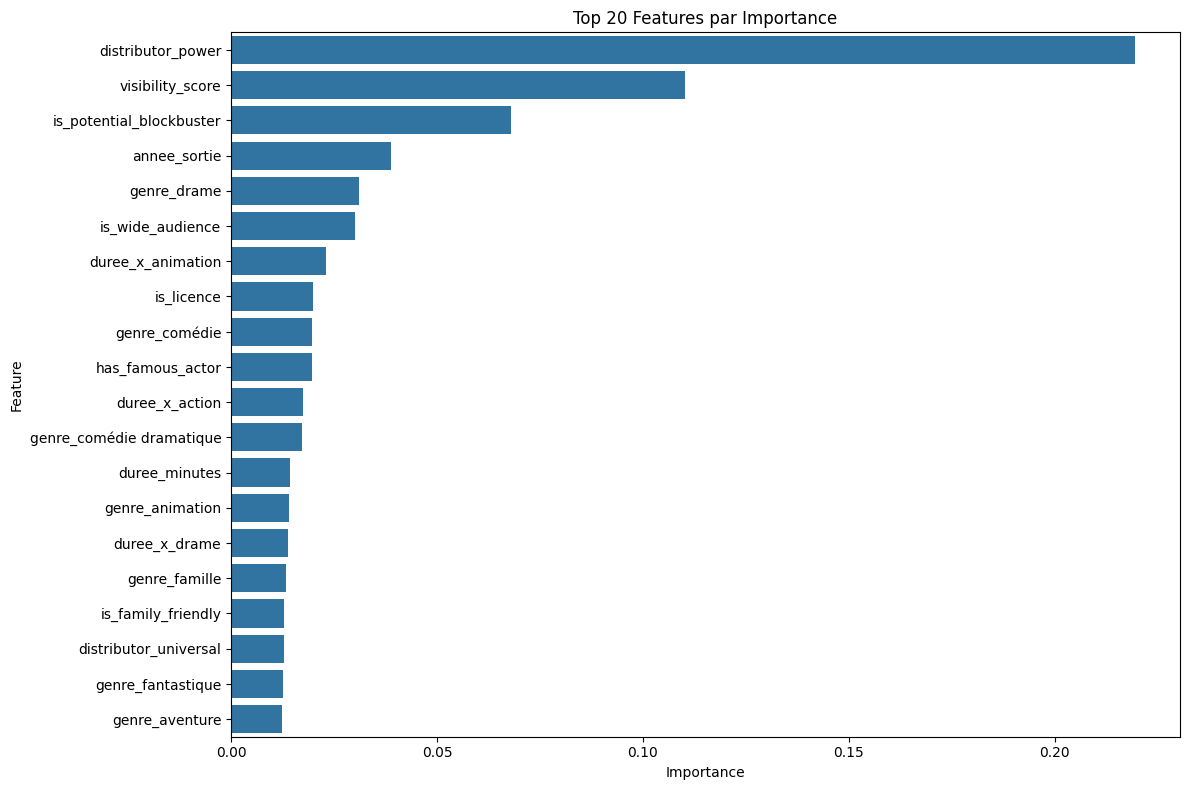


Top 10 features les plus importantes:
                     Feature  Importance
33         distributor_power    0.219448
55          visibility_score    0.110311
56  is_potential_blockbuster    0.068022
2               annee_sortie    0.038903
13               genre_drame    0.031001
26          is_wide_audience    0.030142
66         duree_x_animation    0.023114
42                is_licence    0.019950
12             genre_comédie    0.019664
36          has_famous_actor    0.019623

Analyse des importances de features du modèle spécifique aux blockbusters:


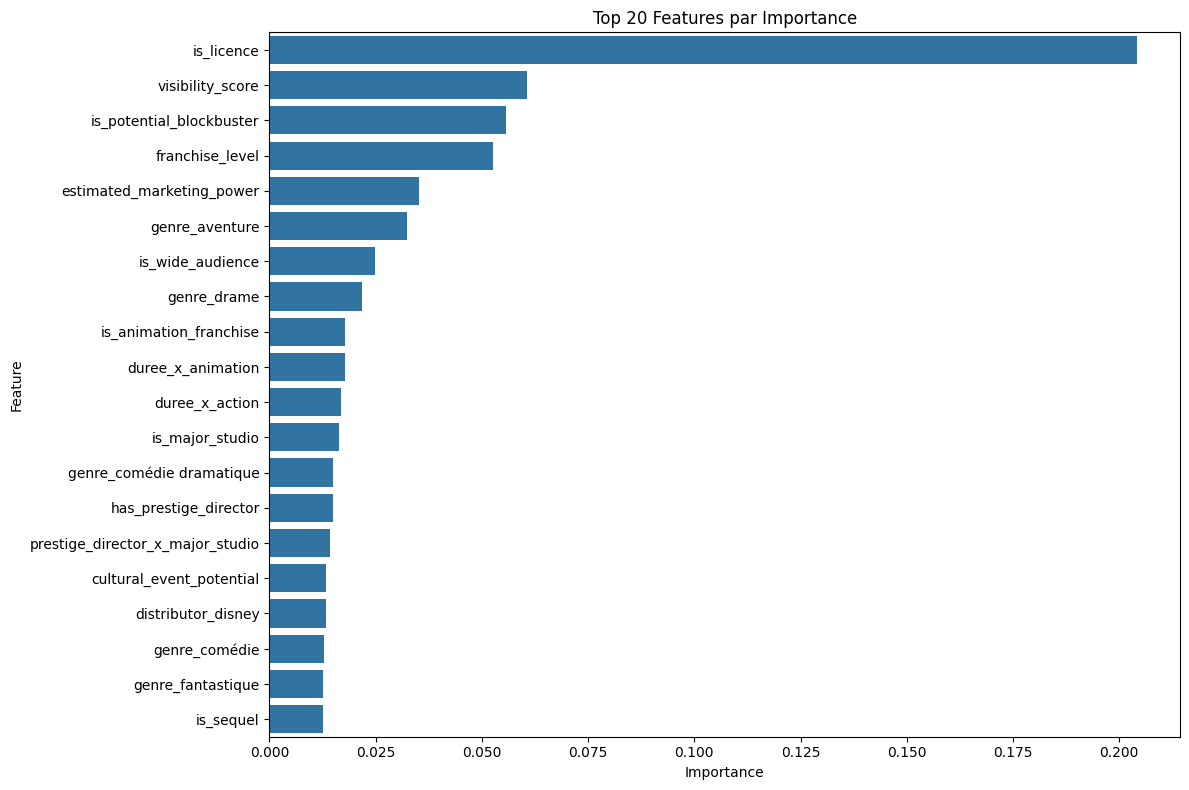


Top 10 features les plus importantes pour les blockbusters:
                      Feature  Importance
42                 is_licence    0.204085
55           visibility_score    0.060614
56   is_potential_blockbuster    0.055778
41            franchise_level    0.052572
53  estimated_marketing_power    0.035218
10             genre_aventure    0.032267
26           is_wide_audience    0.024738
13                genre_drame    0.021766
45     is_animation_franchise    0.017779
66          duree_x_animation    0.017683


In [189]:
# Analyse des importances de features
def plot_feature_importance(model, feature_names, top_n=20):
    # Récupérer les importances
    importances = model.feature_importances_
    
    # Créer un DataFrame pour faciliter le tri
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Trier par importance décroissante
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Limiter aux top_n features
    top_features = feature_importance_df.head(top_n)
    
    # Création du graphique
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Features par Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Afficher les importances si un modèle a été entraîné
if 'final_model' in locals():
    print("\nAnalyse des importances de features du modèle final:")
    importance_df = plot_feature_importance(final_model, available_features)
    print("\nTop 10 features les plus importantes:")
    print(importance_df.head(10))

# Si un modèle spécifique pour blockbusters existe, afficher également ses importances
if 'blockbuster_model' in locals() and blockbuster_model is not None:
    print("\nAnalyse des importances de features du modèle spécifique aux blockbusters:")
    blockbuster_importance_df = plot_feature_importance(blockbuster_model, available_features)
    print("\nTop 10 features les plus importantes pour les blockbusters:")
    print(blockbuster_importance_df.head(10))


Visualisation des prédictions vs valeurs réelles:


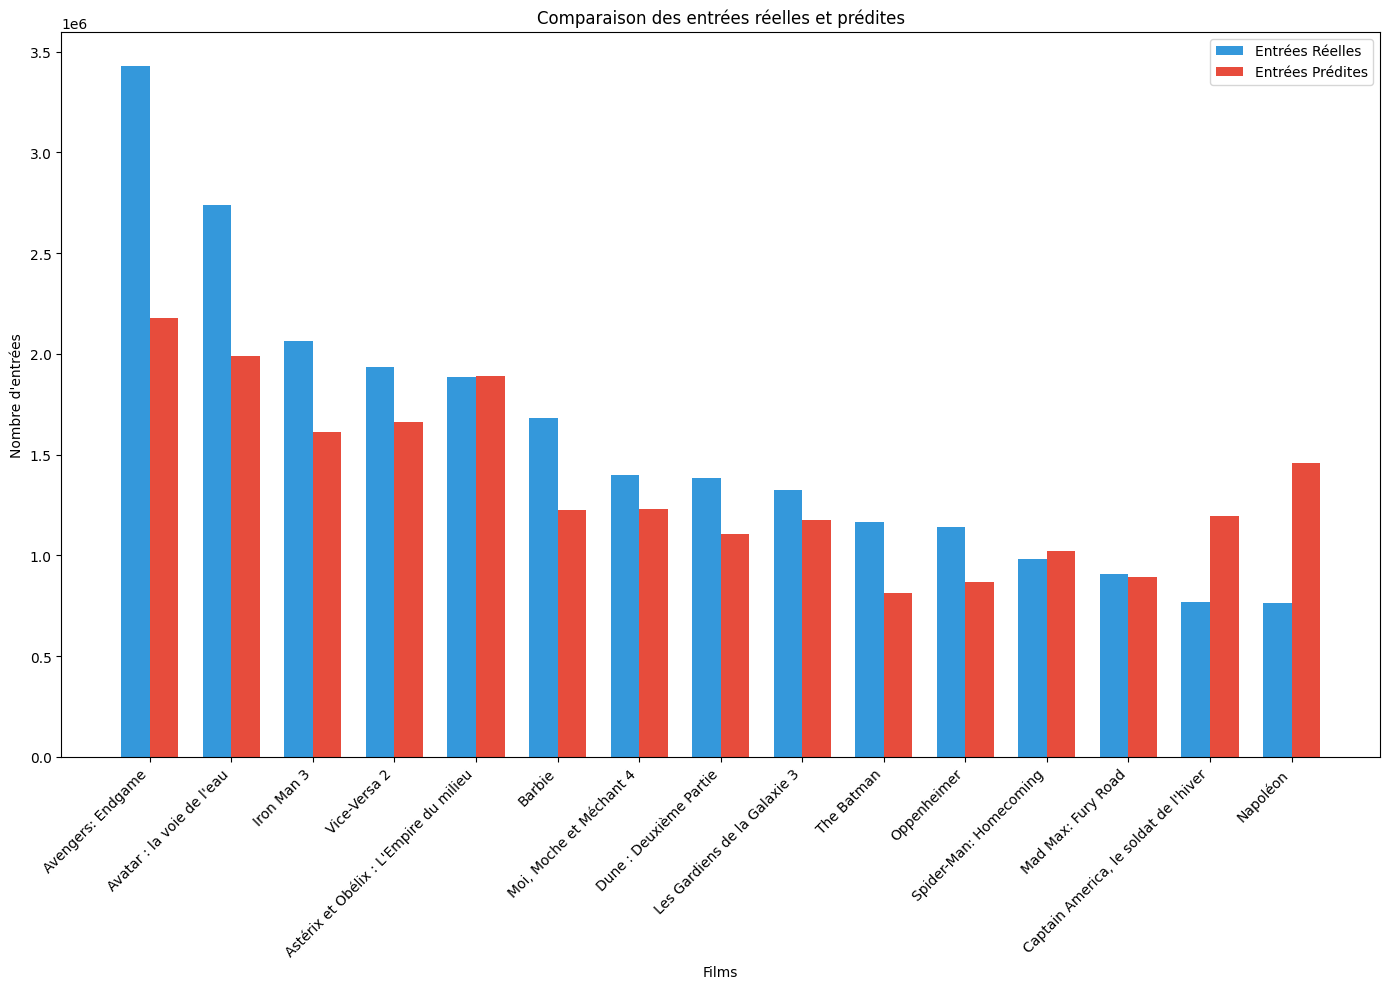

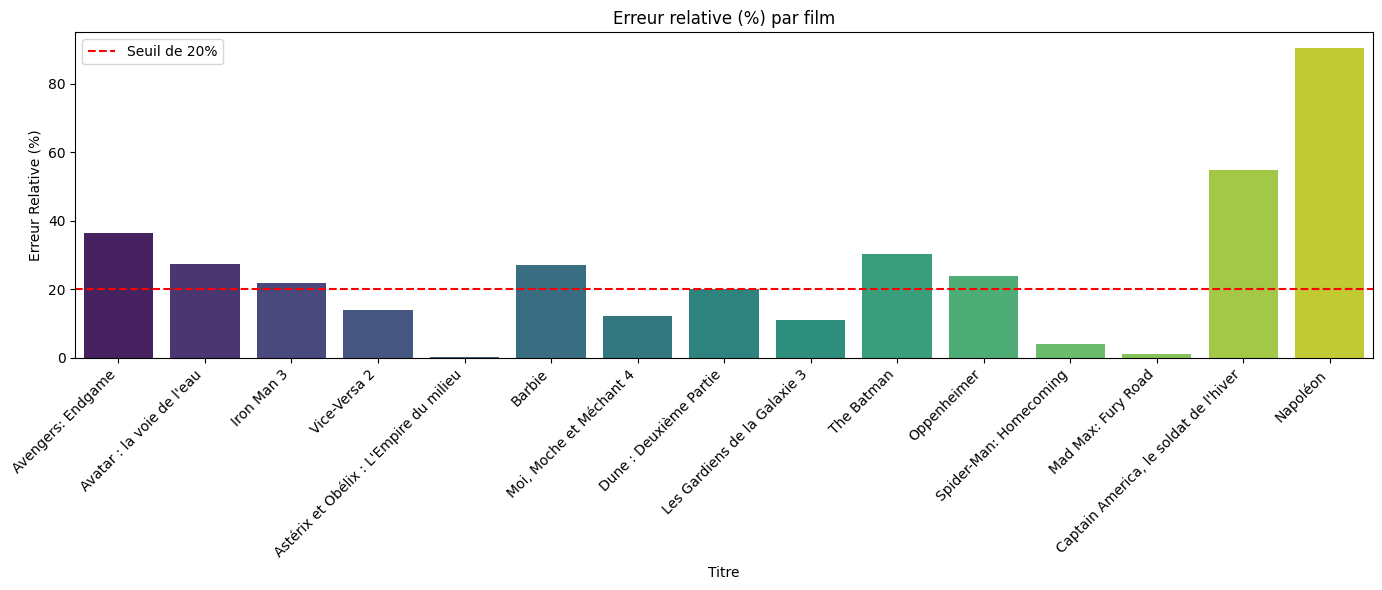

In [190]:
# Visualisation des prédictions vs valeurs réelles
def plot_predictions_vs_actual(y_true, y_pred, film_titles):
    # Créer un DataFrame pour le graphique
    plot_df = pd.DataFrame({
        'Titre': film_titles,
        'Entrées Réelles': y_true,
        'Entrées Prédites': y_pred
    }).dropna()
    
    # Trier par nombre d'entrées réelles décroissant
    plot_df = plot_df.sort_values('Entrées Réelles', ascending=False)
    
    # Créer le graphique à barres
    plt.figure(figsize=(14, 10))
    
    # Positions des barres
    x = np.arange(len(plot_df))
    width = 0.35
    
    # Barres pour les valeurs réelles et prédites
    plt.bar(x - width/2, plot_df['Entrées Réelles'], width, label='Entrées Réelles', color='#3498db')
    plt.bar(x + width/2, plot_df['Entrées Prédites'], width, label='Entrées Prédites', color='#e74c3c')
    
    # Étiquettes et légende
    plt.xlabel('Films')
    plt.ylabel('Nombre d\'entrées')
    plt.title('Comparaison des entrées réelles et prédites')
    plt.xticks(x, plot_df['Titre'], rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Graphique de l'erreur relative
    plot_df['Erreur Relative (%)'] = abs(plot_df['Entrées Réelles'] - plot_df['Entrées Prédites']) / plot_df['Entrées Réelles'] * 100
    
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Titre', y='Erreur Relative (%)', data=plot_df, palette='viridis')
    plt.title('Erreur relative (%) par film')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=20, color='r', linestyle='--', label='Seuil de 20%')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return plot_df

# Visualiser les prédictions vs valeurs réelles
if 'y_pred_base' in locals() and valid_indices.sum() > 0:
    print("\nVisualisation des prédictions vs valeurs réelles:")
    plot_df = plot_predictions_vs_actual(
        y_real_valid, 
        y_pred_valid, 
        df_test.loc[valid_indices, 'titre'].values
    )